# <span style="font-family:cursive;text-align:center">Cyberbullying Detection : </span>

# <span style="font-family:cursive;text-align:center">⬇️ Importing Libraries</span>

In [63]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline


import re
import string
from wordcloud import WordCloud

from textblob import TextBlob

import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import word2vec

from collections import Counter
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.pipeline import Pipeline

import keras
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import pad_sequences
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from tensorflow.keras.optimizers import Adam,SGD

import transformers
from transformers import (AutoTokenizer, 
                          AutoModelForSequenceClassification, 
                          TextClassificationPipeline)

import joblib
from tqdm import tqdm

import contractions
import shap

In [64]:
tf.compat.v1.disable_v2_behavior()

# <span style="font-family:cursive;text-align:center">⬇️ Importing Data</span>

In [65]:
df = pd.read_csv("C:/Users/santh/Downloads/twitter_parsed_dataset.csv")
df

,index,id,Text,Annotation,oh_label
0,5.74948705591165E+017,5.74948705591165E+017,@halalflaws @biebervalue @greenlinerzjm I read...,none,0.0
1,5.71917888690393E+017,5.71917888690393E+017,@ShreyaBafna3 Now you idiots claim that people...,none,0.0
2,3.90255841338601E+017,3.90255841338601E+017,"RT @Mooseoftorment Call me sexist, but when I ...",sexism,1.0
3,5.68208850655916E+017,5.68208850655916E+017,"@g0ssipsquirrelx Wrong, ISIS follows the examp...",racism,1.0
4,5.75596338802373E+017,5.75596338802373E+017,#mkr No No No No No No,none,0.0
...,...,...,...,...,...
16846,5.75606766236475E+017,5.75606766236475E+017,"Feeling so sorry for the girls, they should be...",none,0.0
16847,5.72333822886326E+017,5.72333822886326E+017,#MKR 'pretty good dishes we're happy with' - O...,none,0.0
16848,5.72326950057845E+017,5.72326950057845E+017,RT @colonelkickhead: Deconstructed lemon tart!...,none,0.0
16849,5.74799612642357E+017,5.74799612642357E+017,@versacezaynx @nyazpolitics @greenlinerzjm You...,none,0.0


# <span style="font-family:cursive;text-align:center">📊 Exploratory Data Analysis</span>

0.0    11501
1.0     5347
Name: oh_label, dtype: int64


<AxesSubplot:>

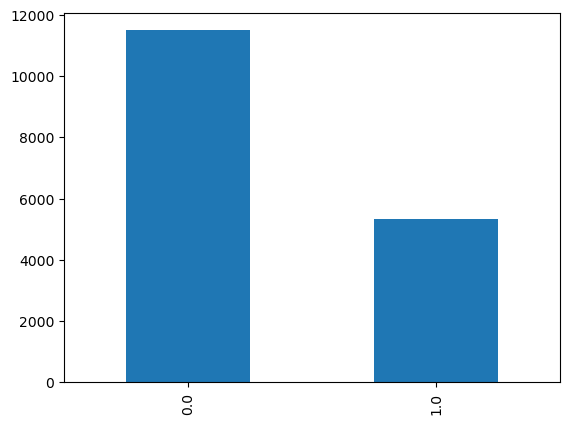

In [66]:
print(df['oh_label'].value_counts())
df['oh_label'].value_counts().plot(kind='bar')

In [67]:
df.describe(include='O')

,index,id,Text,Annotation
count,16851,16850,16850,16848
unique,16851,16850,16850,3
top,5.74948705591165E+017,5.74948705591165E+017,@halalflaws @biebervalue @greenlinerzjm I read...,none
freq,1,1,1,11501


In [68]:
df.describe()

,oh_label
count,16848.000000
mean,0.317367
std,0.465465
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [69]:
df['Annotation'].value_counts()

none      11501
sexism     3377
racism     1970
Name: Annotation, dtype: int64

In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16851 entries, 0 to 16850
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   index       16851 non-null  object 
 1   id          16850 non-null  object 
 2   Text        16850 non-null  object 
 3   Annotation  16848 non-null  object 
 4   oh_label    16848 non-null  float64
dtypes: float64(1), object(4)
memory usage: 658.4+ KB


In [71]:
# drop the unnecessary columns
df = df.drop(['index','id'], axis=1)
df.dropna(inplace=True)

In [72]:
df.oh_label.value_counts()

0.0    11501
1.0     5347
Name: oh_label, dtype: int64

In [73]:
df.head()

,Text,Annotation,oh_label
0,@halalflaws @biebervalue @greenlinerzjm I read...,none,0.0
1,@ShreyaBafna3 Now you idiots claim that people...,none,0.0
2,"RT @Mooseoftorment Call me sexist, but when I ...",sexism,1.0
3,"@g0ssipsquirrelx Wrong, ISIS follows the examp...",racism,1.0
4,#mkr No No No No No No,none,0.0


# <span style="font-family:cursive;text-align:center"> Text cleaning and feature extraction</span>

In [74]:
# Text Cleaning Function:

only_english = set(nltk.corpus.words.words())

def clean_text(text):
    
    sample = text
    sample = " ".join([x.lower() for x in sample.split()])
    sample = re.sub(r"\S*https?:\S*", '', sample) #links and urls
    sample = re.sub('\[.*?\]', '', sample) #text between [square brackets]
    sample = re.sub('\(.*?\)', '', sample) #text between (parenthesis)
    sample = re.sub('#', ' ', sample) #remove hashtags
    sample = ' '.join([x for x in sample.split() if not x.startswith('@')]) # remove mentions with @
    sample = " ".join([contractions.fix(x) for x in sample.split()])  # fixes contractions like you're to you are
    sample = re.sub('[%s]' % re.escape(string.punctuation), ' ', sample) #punctuations
    sample = re.sub('\w*\d\w', '', sample) #digits with trailing or preceeding text
    sample = re.sub(r'\n', ' ', sample) #new line character
    sample = re.sub(r'\\n', ' ', sample) #new line character
    sample = re.sub("[''""...“”‘’…]", '', sample) #list of quotation marks
    sample = " ".join(x.strip() for x in sample.split()) #strips whitespace
    sample = re.sub(r', /<[^>]+>/', '', sample)    #HTML attributes
    
    sample = ' '.join([w for w in nltk.wordpunct_tokenize(sample) if w.lower() in only_english or not w.isalpha()]) #doesn't remove indian languages
    sample = ' '.join(list(filter(lambda ele: re.search("[a-zA-Z\s]+", ele) is not None, sample.split()))) #languages other than english
    
    sample = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE).sub(r'', sample) #emojis and symbols
    sample = sample.strip()
    sample = " ".join([x.strip() for x in sample.split()])
    
    return sample

In [75]:
df['cleaned_text'] = df['Text'].apply(lambda x: clean_text(str(x)))
df.head()

,Text,Annotation,oh_label,cleaned_text
0,@halalflaws @biebervalue @greenlinerzjm I read...,none,0.0,i read them in context no change in meaning th...
1,@ShreyaBafna3 Now you idiots claim that people...,none,0.0,now you claim that people who tried to stop hi...
2,"RT @Mooseoftorment Call me sexist, but when I ...",sexism,1.0,call me but when i go to an auto place i would...
3,"@g0ssipsquirrelx Wrong, ISIS follows the examp...",racism,1.0,wrong the example of and the exactly
4,#mkr No No No No No No,none,0.0,no no no no no no


In [76]:
stops = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
ps = PorterStemmer()

def get_wordnet_pos(word):
    
    treebank_tag = nltk.pos_tag([word])[0][1]
    
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def correct_text(text, stem=False, lemma=False, spell=False):
    if lemma and stem:
        raise Exception('Either stem or lemma can be true, not both!')
        return text
    
    sample = text
    
    #removing stopwords
    sample = sample.lower()
    sample = [word for word in sample.split() if not word in stops]
    sample = ' '.join(sample)
    
    if lemma:
        sample = sample.split()
        sample = [lemmatizer.lemmatize(word.lower(), get_wordnet_pos(word.lower())) for word in sample]
        sample = ' '.join(sample)
        
    if stem:
        sample = sample.split()
        sample = [ps.stem(word) for word in sample]
        sample = ' '.join(sample)
    
    if spell:
        sample = str(TextBlob(text).correct())
    
    return sample

In [77]:
df['correct_text'] = 'text'
df

,Text,Annotation,oh_label,cleaned_text,correct_text
0,@halalflaws @biebervalue @greenlinerzjm I read...,none,0.0,i read them in context no change in meaning th...,text
1,@ShreyaBafna3 Now you idiots claim that people...,none,0.0,now you claim that people who tried to stop hi...,text
2,"RT @Mooseoftorment Call me sexist, but when I ...",sexism,1.0,call me but when i go to an auto place i would...,text
3,"@g0ssipsquirrelx Wrong, ISIS follows the examp...",racism,1.0,wrong the example of and the exactly,text
4,#mkr No No No No No No,none,0.0,no no no no no no,text
...,...,...,...,...,...
16846,"Feeling so sorry for the girls, they should be...",none,0.0,feeling so sorry for the they should be safe a...,text
16847,#MKR 'pretty good dishes we're happy with' - O...,none,0.0,pretty good we are happy with well i am never ...,text
16848,RT @colonelkickhead: Deconstructed lemon tart!...,none,0.0,lemon tart can we please go just one season of...,text
16849,@versacezaynx @nyazpolitics @greenlinerzjm You...,none,0.0,you are too stupid to talk to blocked,text


In [78]:
count = 0
for text in tqdm(df['cleaned_text']):
    df['correct_text'][count] = correct_text(text, lemma=True)
    count +=1

  0%|          | 0/16848 [00:00<?, ?it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 18%|█▊        | 2975/16848 [00:15<01:12, 192.50it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 18%|█▊        | 2995/16848 [00:15<01:14, 185.11it/s]
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
100%|██████████| 16848/16

In [79]:
df['word_count'] = df['correct_text'].apply(lambda x: len(str(x).split(" ")))
df['char_count'] = df['correct_text'].str.len() ## this also includes spaces

In [80]:
df

,Text,Annotation,oh_label,cleaned_text,correct_text,word_count,char_count
0,@halalflaws @biebervalue @greenlinerzjm I read...,none,0.0,i read them in context no change in meaning th...,read context change meaning history slavery,6,43
1,@ShreyaBafna3 Now you idiots claim that people...,none,0.0,now you claim that people who tried to stop hi...,claim people try stop become terrorist make te...,10,64
2,"RT @Mooseoftorment Call me sexist, but when I ...",sexism,1.0,call me but when i go to an auto place i would...,call go auto place would rather talk guy,8,40
3,"@g0ssipsquirrelx Wrong, ISIS follows the examp...",racism,1.0,wrong the example of and the exactly,wrong example exactly,3,21
4,#mkr No No No No No No,none,0.0,no no no no no no,,1,0
...,...,...,...,...,...,...,...
16846,"Feeling so sorry for the girls, they should be...",none,0.0,feeling so sorry for the they should be safe a...,stupid talk block,3,17
16847,#MKR 'pretty good dishes we're happy with' - O...,none,0.0,pretty good we are happy with well i am never ...,protest mad much reason would feminism,6,38
16848,RT @colonelkickhead: Deconstructed lemon tart!...,none,0.0,lemon tart can we please go just one season of...,text,1,4
16849,@versacezaynx @nyazpolitics @greenlinerzjm You...,none,0.0,you are too stupid to talk to blocked,text,1,4


<AxesSubplot:>

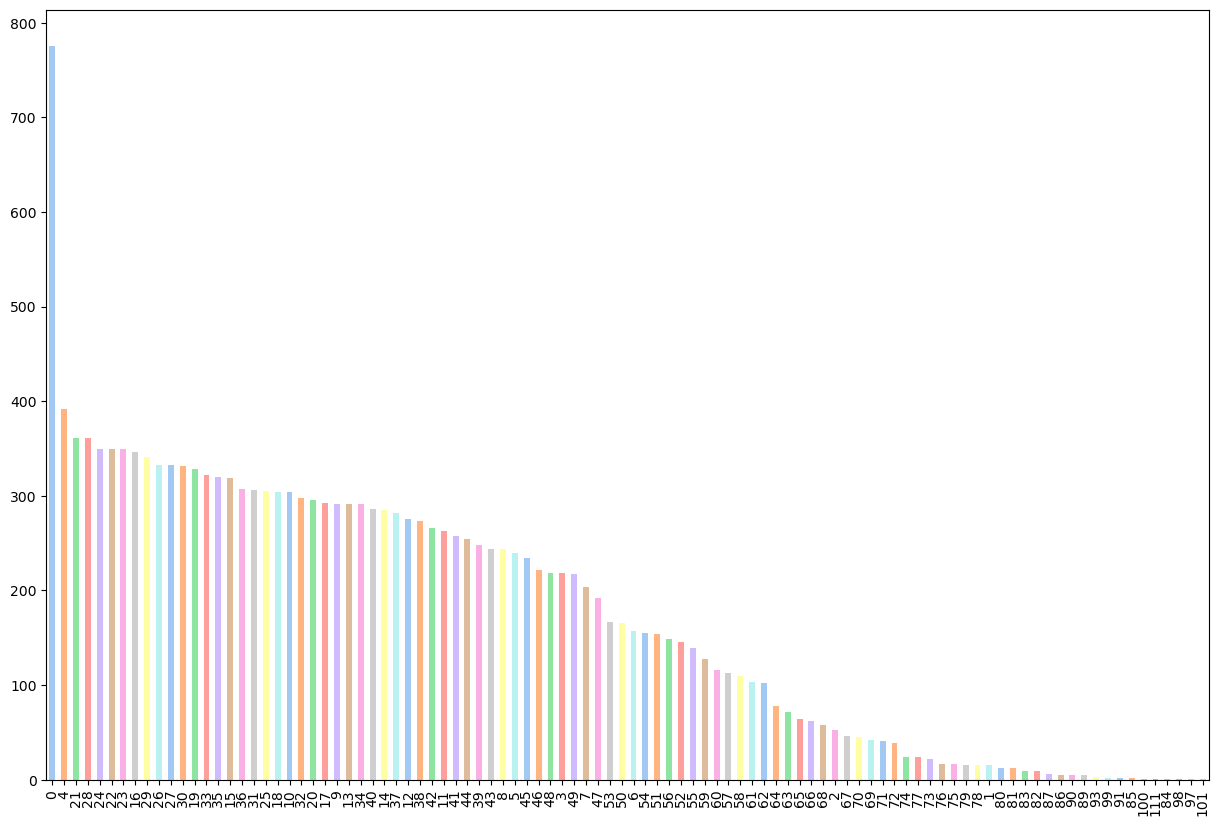

In [81]:
#Checking the Frequency of Character Count(lenght) in the df:

plt.figure(figsize=(15,10))
df['char_count'].value_counts().plot(kind='bar', color=sns.color_palette('pastel'))

In [82]:
#Dropping the Rows with char_count with 0 :

df = df[~(df['char_count']==0)].reset_index(drop=True)

In [83]:
df.shape

(16073, 7)

In [84]:
df[(df['oh_label'] == 0)]

,Text,Annotation,oh_label,cleaned_text,correct_text,word_count,char_count
0,@halalflaws @biebervalue @greenlinerzjm I read...,none,0.0,i read them in context no change in meaning th...,read context change meaning history slavery,6,43
1,@ShreyaBafna3 Now you idiots claim that people...,none,0.0,now you claim that people who tried to stop hi...,claim people try stop become terrorist make te...,10,64
4,RT @TRobinsonNewEra: http://t.co/nkkCbpcHEo Sa...,none,0.0,preacher who and tortured his five year old da...,preacher torture five year old daughter death,7,45
6,Going to make some pancakes.....Don't hve any ...,none,0.0,going to make some do not any but i,go make,2,7
7,RT @ahtweet: @freebsdgirl How dare you have fe...,none,0.0,how dare you have is a fantastic way to dehuma...,dare fantastic way dehumanize someone,5,37
...,...,...,...,...,...,...,...
16068,"Feeling so sorry for the girls, they should be...",none,0.0,feeling so sorry for the they should be safe a...,stupid talk block,3,17
16069,#MKR 'pretty good dishes we're happy with' - O...,none,0.0,pretty good we are happy with well i am never ...,protest mad much reason would feminism,6,38
16070,RT @colonelkickhead: Deconstructed lemon tart!...,none,0.0,lemon tart can we please go just one season of...,text,1,4
16071,@versacezaynx @nyazpolitics @greenlinerzjm You...,none,0.0,you are too stupid to talk to blocked,text,1,4


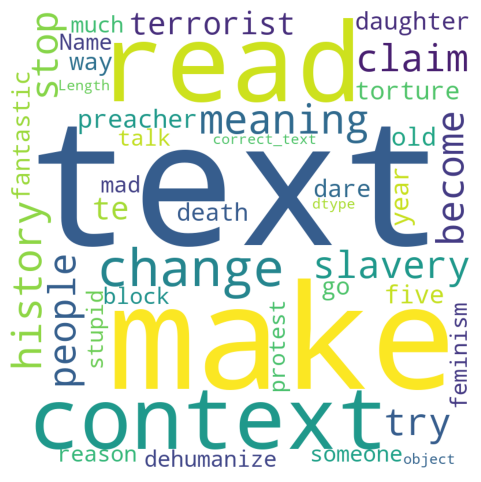

In [85]:
g = str(df[df['oh_label']== 0]['correct_text'])

wordcloud = WordCloud(width = 800, height = 800, background_color ='white', min_font_size = 10).generate(g)
  
# plot the WordCloud image                        
plt.figure(figsize = (6, 6), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
#plt.tight_layout(pad = 0) 
  
plt.show()

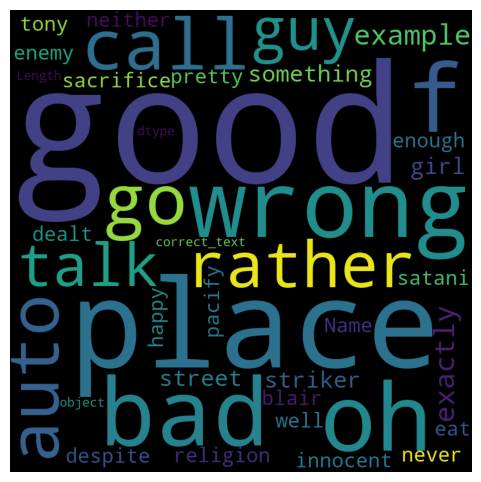

In [86]:
g = str(df[df['oh_label']==1]['correct_text'])

wordcloud = WordCloud(width = 800, height = 800, background_color ='black', min_font_size = 10).generate(g)
  
# plot the WordCloud image                        
plt.figure(figsize = (6, 6), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
#plt.tight_layout(pad = 0) 
  
plt.show()

In [87]:
final_data = df.drop(columns=['Text', 'cleaned_text', 'word_count', 'char_count','Annotation'])

In [88]:
final_data.head()

,oh_label,correct_text
0,0.0,read context change meaning history slavery
1,0.0,claim people try stop become terrorist make te...
2,1.0,call go auto place would rather talk guy
3,1.0,wrong example exactly
4,0.0,preacher torture five year old daughter death


## Building Vocabulary :

In [89]:
# load doc and add to vocab
def build_vocab(vocab_obj, text):
    sample = text
    tokens = [word for word in sample.split()]
    vocab_obj.update(tokens)

def save__vocab_list(vocab, filename):
    lines = [a for a in vocab.keys()]
    # convert lines to a single blob of text
    data = '\n'.join(lines)
    # open file
    file = open(filename, 'w', encoding="utf-8")
    # write text
    file.write(data)
    # close file
    file.close()

In [90]:
vocab = Counter()
for text in final_data['correct_text']:
    build_vocab(vocab, text)

In [91]:
print(vocab.most_common(50))

[('kat', 1080), ('get', 1021), ('like', 1015), ('go', 990), ('would', 747), ('people', 735), ('one', 616), ('make', 607), ('think', 573), ('cannot', 555), ('know', 521), ('see', 507), ('say', 502), ('time', 482), ('well', 453), ('want', 432), ('really', 400), ('good', 398), ('men', 377), ('need', 353), ('call', 347), ('even', 322), ('oh', 305), ('way', 303), ('u', 303), ('bad', 291), ('never', 291), ('look', 289), ('take', 283), ('give', 282), ('right', 279), ('still', 273), ('try', 270), ('talk', 263), ('hate', 262), ('woman', 260), ('work', 249), ('come', 248), ('back', 247), ('watch', 243), ('much', 243), ('stop', 238), ('female', 238), ('use', 233), ('love', 233), ('show', 230), ('ever', 216), ('someone', 210), ('every', 209), ('many', 208)]


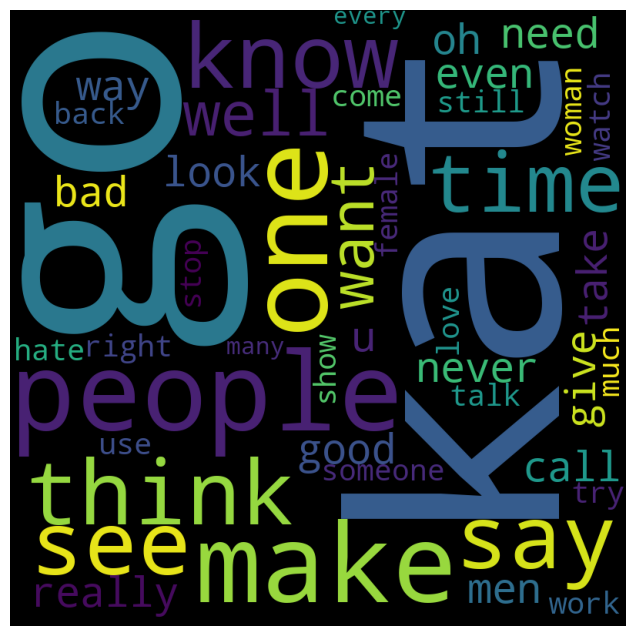

In [92]:
# Plotting the Most Repeated Words: 

g = " ".join([x[0] for x in vocab.most_common(50)])

wordcloud = WordCloud(width = 800, height = 800, background_color ='black', min_font_size = 10).generate(g)
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
#plt.tight_layout(pad = 0) 
  
plt.show()

In [93]:
save__vocab_list(vocab, 'vocab.txt')

# <span style="font-family:cursive;text-align:center">📌 Modelling :</span>

In [94]:
def create_tokenizer(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer


def encode_docs(tokenizer, max_length, docs):
    # integer encode
    encoded = tokenizer.texts_to_sequences(docs)
    # pad sequences
    padded = pad_sequences(encoded, maxlen=max_length, padding='post')
    return padded

In [95]:
X = final_data['correct_text']
y = final_data['oh_label']

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=101)

In [97]:
X_train.fillna(" ", axis=0, inplace=True)
X_test.fillna(" ", axis=0, inplace=True)
y_train.fillna(0.0, inplace=True)
y_test.fillna(1.0, inplace=True)

In [98]:
vocab_set = set([x for x in vocab if len(x)>2])

tokenizer = create_tokenizer(X_train.values)
vocab_size = len(tokenizer.word_index) + 1
max_length = max([len(s.split()) for s in X_train])

In [99]:
x_train = encode_docs(tokenizer, max_length, X_train.values)
x_test = encode_docs(tokenizer, max_length, X_test.values)

In [100]:
model = Sequential()

model.add(Embedding(vocab_size,100, input_length=max_length))
model.add(Flatten(input_shape=(x_train.shape[1],)))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 19, 100)           583200    
                                                                 
 flatten_3 (Flatten)         (None, 1900)              0         
                                                                 
 dense_8 (Dense)             (None, 128)               243328    
                                                                 
 dense_9 (Dense)             (None, 64)                8256      
                                                                 
 dense_10 (Dense)            (None, 1)                 65        
                                                                 
Total params: 834,849
Trainable params: 834,849
Non-trainable params: 0
_________________________________________________________________


In [101]:
model.fit(x_train, y_train.values, epochs=10, verbose=2, batch_size=74)

Train on 10768 samples
Epoch 1/10
10768/10768 - 1s - loss: 0.6291 - acc: 0.6781 - 1s/epoch - 116us/sample
Epoch 2/10
10768/10768 - 1s - loss: 0.5525 - acc: 0.7171 - 1s/epoch - 101us/sample
Epoch 3/10
10768/10768 - 1s - loss: 0.3284 - acc: 0.8613 - 1s/epoch - 105us/sample
Epoch 4/10
10768/10768 - 1s - loss: 0.2201 - acc: 0.9093 - 1s/epoch - 102us/sample
Epoch 5/10
10768/10768 - 1s - loss: 0.1726 - acc: 0.9290 - 1s/epoch - 98us/sample
Epoch 6/10
10768/10768 - 1s - loss: 0.1469 - acc: 0.9375 - 1s/epoch - 100us/sample
Epoch 7/10
10768/10768 - 1s - loss: 0.1240 - acc: 0.9447 - 1s/epoch - 97us/sample
Epoch 8/10
10768/10768 - 1s - loss: 0.1063 - acc: 0.9492 - 1s/epoch - 100us/sample
Epoch 9/10
10768/10768 - 1s - loss: 0.0962 - acc: 0.9531 - 1s/epoch - 99us/sample
Epoch 10/10
10768/10768 - 1s - loss: 0.0842 - acc: 0.9548 - 1s/epoch - 97us/sample


In [102]:
model.evaluate(x_train, y_train, verbose=0)[1]

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


0.9680535

In [103]:
def predict_sentiment(text, vocab=vocab_set, tokenizer=tokenizer, max_length=max_length, model=model):
    line = text
    # clean review
    line = clean_text(line)
    line = correct_text(line)
    line = " ".join([word for word in line.split() if word in vocab])
    # encode and pad review
    padded = encode_docs(tokenizer, max_length, [line])
    # predict sentiment
    yhat = model.predict(padded, verbose=0)
#     print(yhat)
    # retrieve predicted percentage and label
    percent_pos = yhat[0,0]
    if round(percent_pos) == 0:
        return (1-percent_pos), 'NEGATIVE'
    return percent_pos, 'POSITIVE'

In [104]:
predict_sentiment(final_data['correct_text'][126], vocab_set, tokenizer, max_length, model)

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


(0.6463286280632019, 'NEGATIVE')

In [56]:
#Saving the Model:

model.save('cyberbullying_detection_model.h5')